In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot: xlabel='Date'>

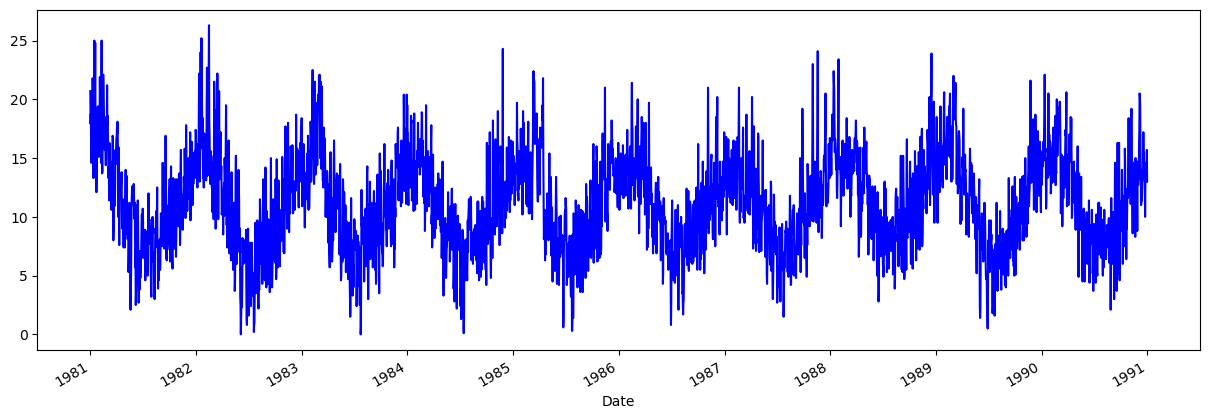

In [3]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [5]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [6]:
seq_len = 21
bs =16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (139, 21, 1)
Note: last 0 data excluded

(N, S, F): (34, 21, 1)
Note: last 15 data excluded



# Arsitektur & Config

In [7]:
from jcopdl.layers import linear_block

In [8]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden


In [9]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0,
    "seg_len": train_set.n_seq
})


# Training Preparation -> MCOC

In [10]:
model = GRU(
    config.input_size,
    config.output_size,
    config.hidden_size,
    config.num_layers,
    config.dropout
).to(device)

criterion = nn.MSELoss(reduction="mean")

optimizer = optim.AdamW(model.parameters(), lr=0.001)

callback = Callback(model, config, outdir="model/gru")

# Training

In [11]:
from tqdm.auto import tqdm

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    
    cost = 0.0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 118.2586 | Test_cost  = 101.1292 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 80.6234 | Test_cost  = 70.7277 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 59.2974 | Test_cost  = 56.6748 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 48.4361 | Test_cost  = 47.6981 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 40.8813 | Test_cost  = 40.8052 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 35.0004 | Test_cost  = 35.3098 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 30.3488 | Test_cost  = 30.9393 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 26.7030 | Test_cost  = 27.5058 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 23.8888 | Test_cost  = 24.8449 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 21.7517 | Test_cost  = 22.8093 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 20.1546 | Test_cost  = 21.2711 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 18.9805 | Test_cost  = 20.1225 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 18.1317 | Test_cost  = 19.2745 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 17.5286 | Test_cost  = 18.6552 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 17.1077 | Test_cost  = 18.2075 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 16.8193 | Test_cost  = 17.8865 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 16.6252 | Test_cost  = 17.6579 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 16.4968 | Test_cost  = 17.4959 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 16.4132 | Test_cost  = 17.3813 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 16.3596 | Test_cost  = 17.3002 | 


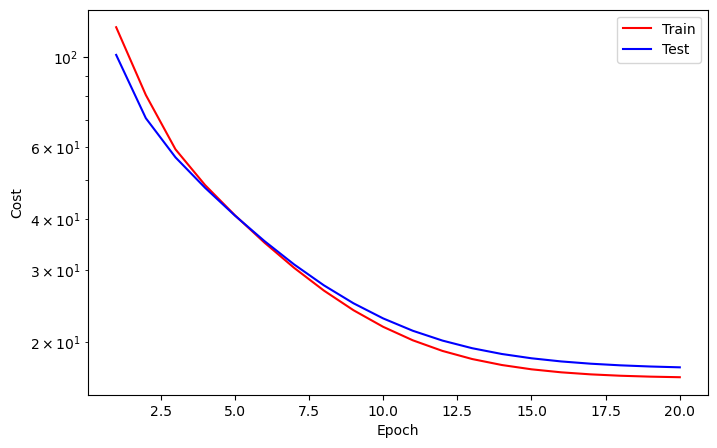

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 16.3255 | Test_cost  = 17.2428 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 16.3038 | Test_cost  = 17.2019 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 16.2900 | Test_cost  = 17.1728 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 16.2809 | Test_cost  = 17.1518 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 16.2747 | Test_cost  = 17.1367 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 16.2702 | Test_cost  = 17.1257 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 16.2666 | Test_cost  = 17.1177 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 16.2636 | Test_cost  = 17.1118 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 16.2608 | Test_cost  = 17.1074 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 16.2582 | Test_cost  = 17.1041 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 16.2557 | Test_cost  = 17.1015 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 16.2532 | Test_cost  = 17.0994 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 16.2507 | Test_cost  = 17.0977 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 16.2482 | Test_cost  = 17.0962 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 16.2457 | Test_cost  = 17.0949 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 16.2431 | Test_cost  = 17.0936 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 16.2405 | Test_cost  = 17.0924 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 16.2378 | Test_cost  = 17.0912 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 16.2351 | Test_cost  = 17.0900 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 16.2324 | Test_cost  = 17.0889 | 


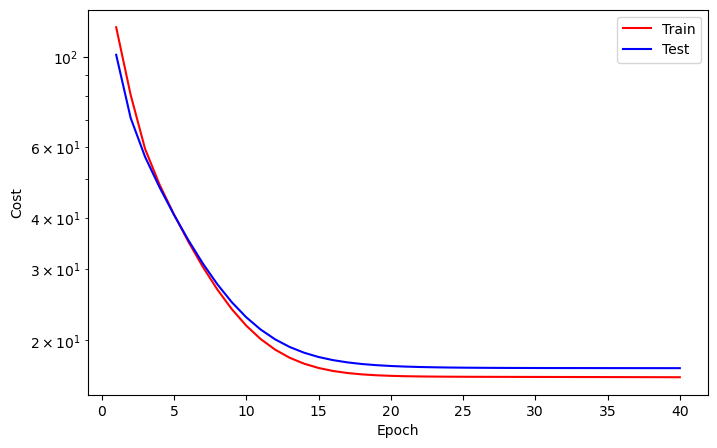

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 16.2296 | Test_cost  = 17.0877 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 16.2268 | Test_cost  = 17.0864 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 16.2240 | Test_cost  = 17.0852 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16.2211 | Test_cost  = 17.0839 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16.2182 | Test_cost  = 17.0826 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 16.2152 | Test_cost  = 17.0813 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 16.2123 | Test_cost  = 17.0799 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 16.2093 | Test_cost  = 17.0785 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 16.2062 | Test_cost  = 17.0770 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 16.2032 | Test_cost  = 17.0754 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 16.2000 | Test_cost  = 17.0738 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 16.1968 | Test_cost  = 17.0721 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 16.1934 | Test_cost  = 17.0702 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 16.1899 | Test_cost  = 17.0680 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 16.1861 | Test_cost  = 17.0655 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 16.1818 | Test_cost  = 17.0624 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 16.1768 | Test_cost  = 17.0586 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 16.1707 | Test_cost  = 17.0534 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 16.1625 | Test_cost  = 17.0451 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 16.1498 | Test_cost  = 17.0297 | 


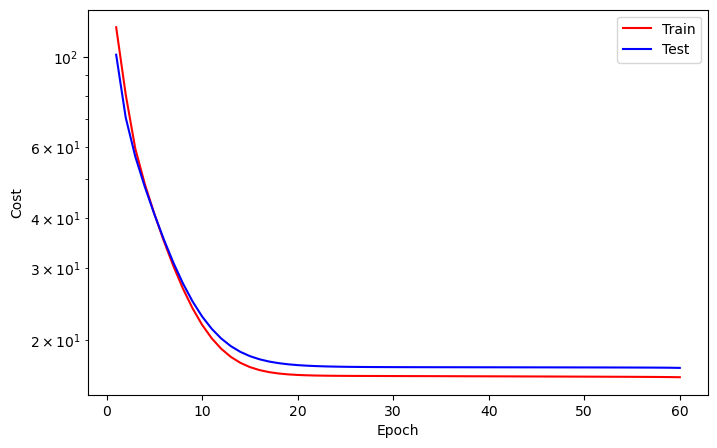

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 16.1250 | Test_cost  = 16.9937 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 16.0625 | Test_cost  = 16.8826 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 15.8324 | Test_cost  = 16.3248 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 14.6503 | Test_cost  = 13.9939 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 12.7544 | Test_cost  = 12.4147 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 11.3757 | Test_cost  = 11.1658 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 10.3593 | Test_cost  = 10.2404 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 9.6591 | Test_cost  = 9.5991 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 9.1725 | Test_cost  = 9.0163 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 8.7704 | Test_cost  = 8.4458 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 8.4139 | Test_cost  = 7.9350 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 8.0869 | Test_cost  = 7.5279 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 7.8024 | Test_cost  = 7.2230 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 7.5737 | Test_cost  = 6.9860 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 7.3920 | Test_cost  = 6.7931 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 7.2446 | Test_cost  = 6.6320 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 7.1231 | Test_cost  = 6.4915 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 7.0206 | Test_cost  = 6.3695 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 6.9342 | Test_cost  = 6.2634 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 6.8602 | Test_cost  = 6.1712 | 


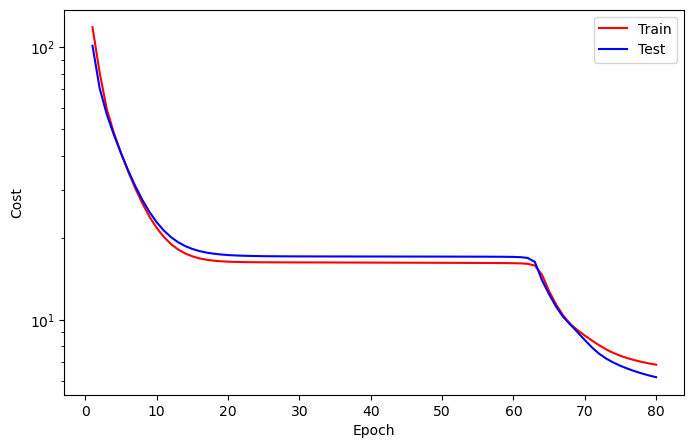

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 6.7961 | Test_cost  = 6.0901 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 6.7392 | Test_cost  = 6.0185 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 6.6882 | Test_cost  = 5.9543 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 6.6420 | Test_cost  = 5.8957 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 6.6004 | Test_cost  = 5.8425 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 6.5631 | Test_cost  = 5.7945 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 6.5292 | Test_cost  = 5.7512 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 6.4984 | Test_cost  = 5.7117 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 6.4702 | Test_cost  = 5.6755 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 6.4443 | Test_cost  = 5.6421 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 6.4205 | Test_cost  = 5.6113 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 6.3984 | Test_cost  = 5.5826 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 6.3780 | Test_cost  = 5.5556 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 6.3592 | Test_cost  = 5.5301 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 6.3418 | Test_cost  = 5.5058 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 6.3256 | Test_cost  = 5.4826 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 6.3105 | Test_cost  = 5.4605 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 6.2964 | Test_cost  = 5.4398 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 6.2833 | Test_cost  = 5.4209 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 6.2710 | Test_cost  = 5.4044 | 


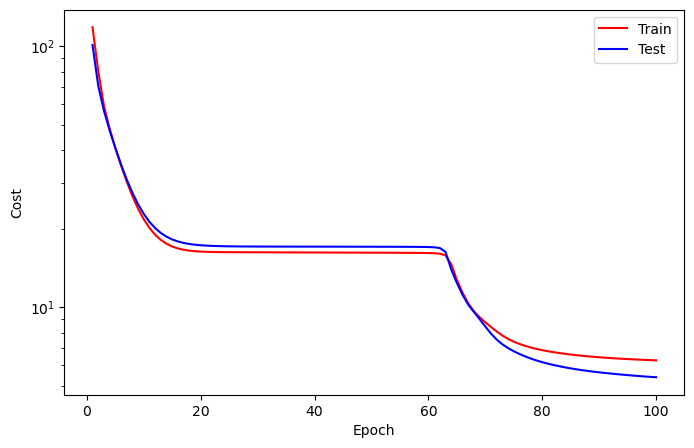

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 6.2594 | Test_cost  = 5.3911 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 6.2485 | Test_cost  = 5.3818 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 6.2379 | Test_cost  = 5.3769 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 6.2273 | Test_cost  = 5.3764 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 6.2164 | Test_cost  = 5.3790 | 
==> EarlyStop patience =  1 | Best test_cost: 5.3764


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 6.2048 | Test_cost  = 5.3822 | 
==> EarlyStop patience =  2 | Best test_cost: 5.3764


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 6.1921 | Test_cost  = 5.3824 | 
==> EarlyStop patience =  3 | Best test_cost: 5.3764


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 6.1781 | Test_cost  = 5.3763 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 6.1627 | Test_cost  = 5.3620 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 6.1460 | Test_cost  = 5.3407 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 6.1285 | Test_cost  = 5.3154 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 6.1103 | Test_cost  = 5.2903 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 6.0922 | Test_cost  = 5.2684 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 6.0747 | Test_cost  = 5.2511 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 6.0586 | Test_cost  = 5.2378 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 6.0439 | Test_cost  = 5.2277 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 6.0306 | Test_cost  = 5.2197 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 6.0184 | Test_cost  = 5.2133 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 6.0070 | Test_cost  = 5.2080 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 5.9963 | Test_cost  = 5.2034 | 


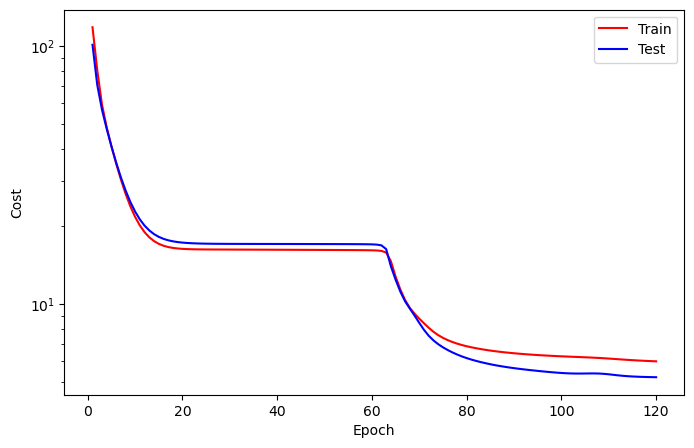

Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 5.9861 | Test_cost  = 5.1995 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 5.9764 | Test_cost  = 5.1960 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 5.9669 | Test_cost  = 5.1931 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 5.9577 | Test_cost  = 5.1905 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 5.9488 | Test_cost  = 5.1882 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 5.9400 | Test_cost  = 5.1863 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 5.9314 | Test_cost  = 5.1848 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 5.9230 | Test_cost  = 5.1835 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 5.9148 | Test_cost  = 5.1826 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 5.9067 | Test_cost  = 5.1819 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 5.8987 | Test_cost  = 5.1816 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 5.8908 | Test_cost  = 5.1815 | 


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 5.8831 | Test_cost  = 5.1818 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1815


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 5.8755 | Test_cost  = 5.1823 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1815


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 5.8680 | Test_cost  = 5.1831 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1815


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 5.8606 | Test_cost  = 5.1841 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1815


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 5.8533 | Test_cost  = 5.1853 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1815
==> Execute Early Stopping at epoch: 137 | Best test_cost: 5.1815
==> Best model is saved at model/gru


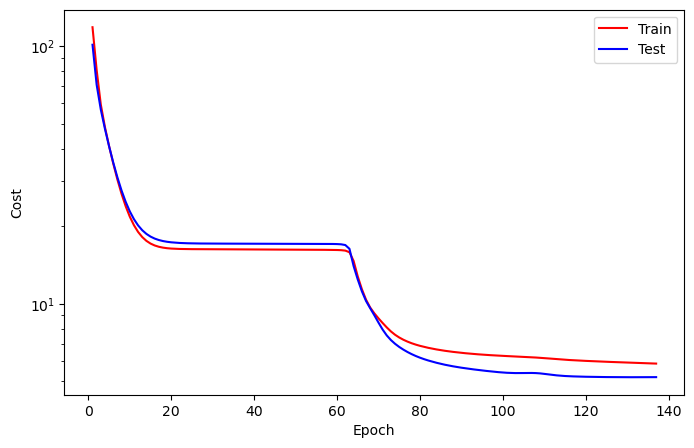

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
train_forecast_loader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
test_forecast_loader = DataLoader(test_forecast_set)


(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

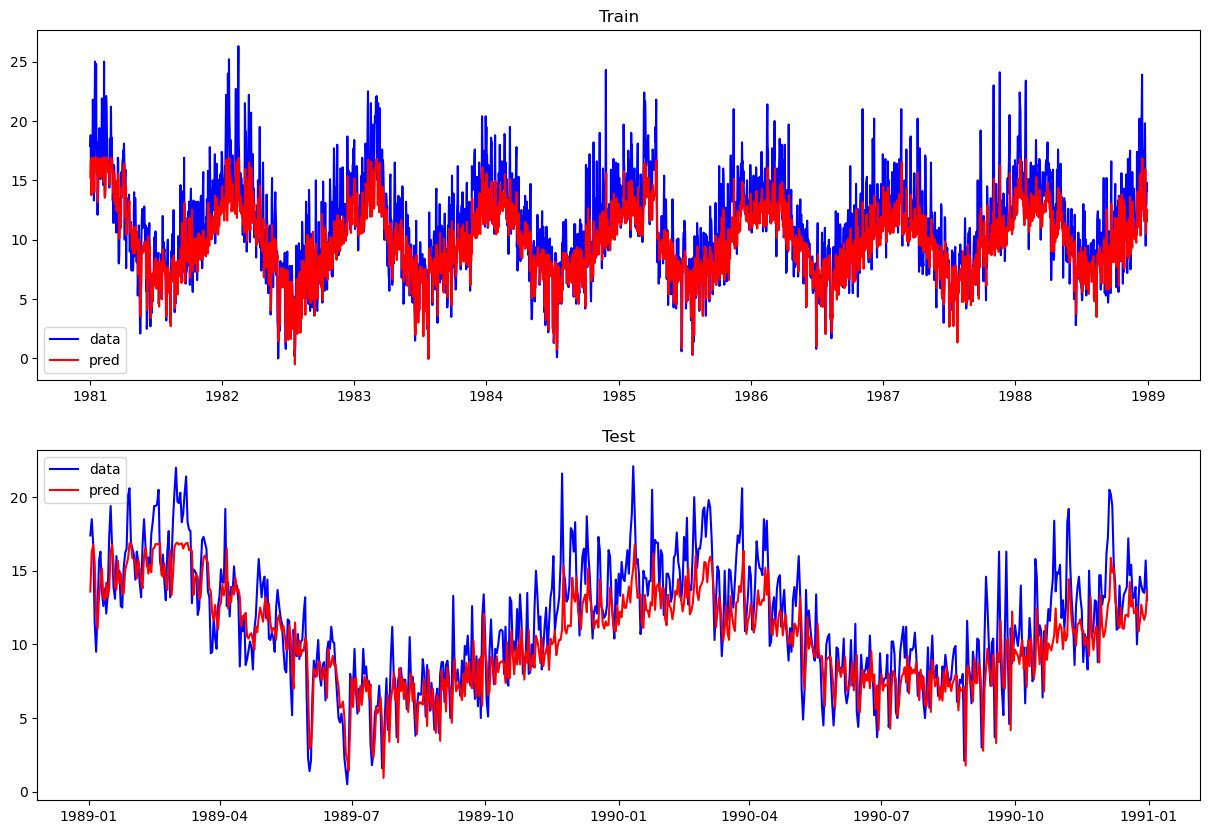

In [16]:
plt.figure(figsize=(15, 10))

# Plot untuk data training
plt.subplot(2, 1, 1)
data4pred(model, train_forecast_set, train_forecast_loader, device)
plt.title("Train")

# Plot untuk data testing
plt.subplot(2, 1, 2)
data4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title("Test")

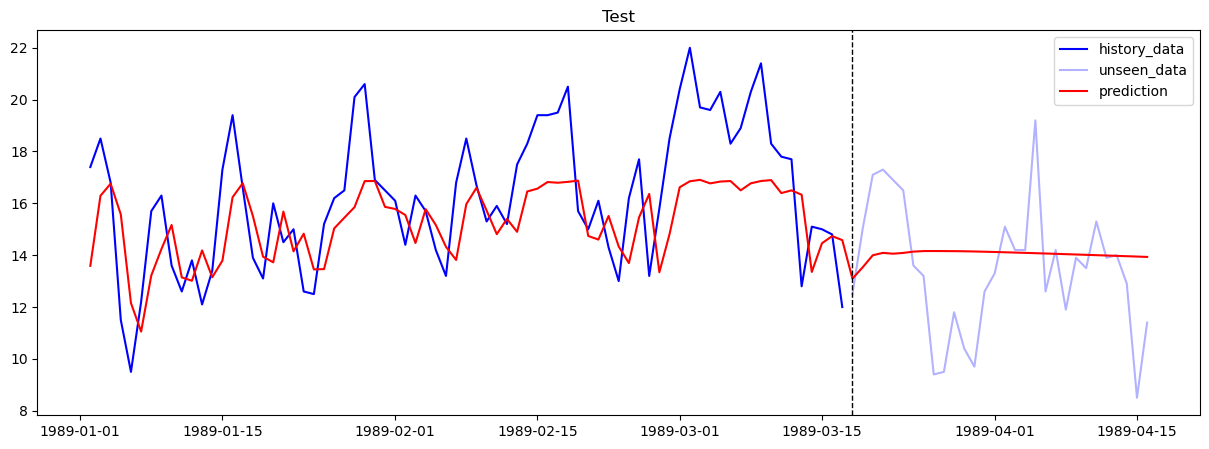

In [17]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title("Test");